# Jigsaw solver


# This method predicts the position and rotation of individual tiles

# Mount Drive

In [1]:
from google.colab import drive
from matplotlib import pyplot as plt
drive.mount('/content/drive/')

Mounted at /content/drive/


# Generate permutations

In [2]:
jigsaw_puzzle_size = 4
num_permuts_saved = 10000
images_dir =  "/content/drive/MyDrive/Final Project/Temp2"

In [3]:
import itertools
import random

import numpy as np

from scipy.spatial.distance import hamming

# Build list of permutations such that each position is equally likely for each piece
piece_indicies = [i for i in range(jigsaw_puzzle_size ** 2)]
num_permuts = num_permuts_saved
permuts = np.zeros((num_permuts_saved, jigsaw_puzzle_size ** 2), dtype=np.long)
permuts_hash = {}
count = 0
while count < num_permuts:
  x = np.array(np.random.permutation(piece_indicies))
  y = np.array(np.random.permutation(piece_indicies), dtype=np.int32)
  hd = hamming(x, y) > 0.9
  x_hashcode = np.sum([10**(-1 * i) * x[i] for i in range(len(x))])
  y_hashcode = np.sum([10**(-1 * i) * y[i] for i in range(len(y))])
  if hd > 0.9 and (not x_hashcode in permuts_hash) and (not y_hashcode in permuts_hash):
    permuts[count] = x
    permuts[count + 1] = y
    permuts_hash[x_hashcode] = True
    permuts_hash[y_hashcode] = True
    count = count + 2



# Build the array for selected permutation indices above
np.save('selected_permuts.npy', permuts)


In [4]:
from ctypes import ArgumentError
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms


def_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

hflip_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

darkness_jitter_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(brightness=[0.5, 0.9]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

lightness_jitter_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ColorJitter(brightness=[1.1, 1.5]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

rotations_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

all_in_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomRotation(degrees=15),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


def crop_from_center(pil_image, new_h, new_w):

    width, height = pil_image.size  # Get dimensions

    left = (width - new_w) / 2
    top = (height - new_h) / 2
    right = (width + new_w) / 2
    bottom = (height + new_h) / 2

    # Crop the center of the image
    pil_image = pil_image.crop((left, top, right, bottom))

    return pil_image


def get_nine_crops(pil_image):
    """
    Get nine crops for a square pillow image. That is height and width of the image should be same.
    :param pil_image: pillow image
    :return: List of pillow images. The nine crops
    """
    w, h = pil_image.size
    diff = int(w/3)

    r_vals = [0, diff, 2 * diff]
    c_vals = [0, diff, 2 * diff]

    list_patches = []

    for r in r_vals:
        for c in c_vals:

            left = c
            top = r
            right = c + diff
            bottom = r + diff

            patch = pil_image.crop((left, top, right, bottom))
            list_patches.append(patch)

    return list_patches


def get_several_crops(pil_image, jig_size):
    """
    Get several crops for a square pillow image. That is height and width of the image should be same.
    :param pil_image: pillow image
    :param jig_size: number of rows and columns for jigsaw
    :return: List of pillow images. The nine crops
    """
    w, h = pil_image.size
    diff = int(w/jig_size)

    r_vals = [i * diff for i in range(jig_size)]
    c_vals = [i * diff for i in range(jig_size)]

    list_patches = []

    for r in r_vals:
        for c in c_vals:

            left = c
            top = r
            right = c + diff
            bottom = r + diff

            patch = pil_image.crop((left, top, right, bottom))
            list_patches.append(patch)

    return list_patches


def split_train_into_train_val(train_file_ids, train_file_paths, train_labels, test_size=0.1):
    """
    Split train_file_paths and train_labels to train_file_paths, val_file_paths and
    train_labels, val_labels
    """

    # Create a mapping between image_id and file_path
    image_id_name_map = dict(zip(train_file_ids, train_file_paths))

    # Get validation files and validation labels separate
    train_file_ids, val_file_ids, train_labels, val_labels = train_test_split(
        train_file_ids, train_labels, test_size=test_size, random_state=5, shuffle=True
    )
    train_file_paths = [image_id_name_map[image_id] for image_id in train_file_ids]
    val_file_paths = [image_id_name_map[image_id] for image_id in val_file_ids]

    print ("Length of train files list", len(train_file_paths))
    print ("Length of train labels", len(train_labels))
    print ("Length of val files list", len(val_file_paths))
    print ("Length of val labels", len(val_labels))

    return train_file_ids, val_file_ids, train_file_paths, val_file_paths, train_labels, val_labels

def get_paths():
    data_dir = images_dir
    file_paths_to_return = []

    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".jpg"):
                file_paths_to_return.append(data_dir+'/'+file)

    if len(file_paths_to_return) == 0:
      raise ArgumentError("Data was not found. Ensure that a data folder is present")

    return file_paths_to_return

def get_train_test_file_paths_n_labels():
    """
    Get array train_file_paths, train_labels, test_file_paths and test_labels
    """

    # Data loading and data generators set up
    #par_data_dir = 'train'
    images_data_dir = 'train'
    train_test_split_file = 'train_test_split.txt'
    images_file = 'images.txt'
    labels_file = 'image_class_labels.txt'

    # Read the images_file which stores image-id and image-name mapping
    image_file_id_df = pd.read_csv(images_file, sep=' ', header=None)
    image_file_id_mat = image_file_id_df.values
    image_id_name_map = dict(zip(image_file_id_mat[:, 0], image_file_id_mat[:, 1]))

    # Read the train_test_split file which stores image-id and train-test split mapping
    image_id_train_test_split_df = pd.read_csv(train_test_split_file, sep=' ', header=None)
    image_id_train_test_split_mat = image_id_train_test_split_df.values
    image_id_train_test_split_map = dict(zip(image_id_train_test_split_mat[:, 0],
                                             image_id_train_test_split_mat[:, 1]))

    # Read the image class labels file
    image_id_label_df = pd.read_csv(labels_file, sep=' ', header=None)
    image_id_label_mat = image_id_label_df.values
    image_id_label_map = dict(zip(image_id_label_mat[:, 0], image_id_label_mat[:, 1]))

    # Put together train_files train_labels test_files and test_labels lists
    train_image_ids, test_image_ids = [], []
    train_file_paths, test_file_paths = [], []
    train_labels, test_labels = [], []
    for file_id in image_id_name_map.keys():
        file_name = image_id_name_map[file_id]
        is_train = image_id_train_test_split_map[file_id]
        label = image_id_label_map[file_id] - 1  # To ensure labels start from 0

        if is_train:
            train_image_ids.append(file_id)
            train_file_paths.append(os.path.join(images_data_dir, file_name))
            train_labels.append(label)
        else:
            test_image_ids.append(file_id)
            test_file_paths.append(os.path.join(images_data_dir, file_name))
            test_labels.append(label)

    print ("Length of train files list", len(train_file_paths))
    print ("Length of train labels list", len(train_labels))
    print ("Length of test files list", len(test_file_paths))
    print ("Length of test labels list", len(test_labels))

    return train_image_ids, test_image_ids, train_file_paths, test_file_paths, train_labels, test_labels



# Generate Jigsaw from permutations

In [5]:
import json
import numpy as np
import random

import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms.functional import rotate
import torch.nn.functional


class GetDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, labels, transform=None):
        'Initialization'
        self.imgs = [(img_path, label) for img_path, label in zip(file_paths, labels)]
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_paths)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Select sample
        file_path = self.file_paths[index]
        label = self.labels[index]
        pil_image = Image.open(file_path)

        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
            file_path = self.file_paths[0]
            label = self.labels[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        tr_image = self.transform(pil_image)

        return tr_image, label


class GetJigsawPuzzleDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_paths, avail_permuts_file_path, range_permut_indices=None, jig_size=4):
        'Initialization'
        self.file_paths = file_paths
        self.permuts_avail = np.load(avail_permuts_file_path)
        self.jig_size = jig_size
        if range_permut_indices != None:
          self.range_permut_indices = range_permut_indices
        else:
          self.range_permut_indices = (0, len(self.permuts_avail) - 1)


        self.data_transform = transforms.Compose([
            # transforms.ColorJitter(brightness=[0.5, 1.5]),
            transforms.ToTensor(),
        ])
        self.size = len(self.file_paths) * (self.jig_size ** 2) * 4


    def __len__(self):
        'Denotes the total number of samples'
        return self.size

    def __getitem__(self, index):
        'Generates one sample of data'
        num_tiles = self.jig_size ** 2
        num_rotations = 4
        file_index = index // (num_tiles * num_rotations)
        rest = index % (num_tiles * num_rotations)
        rotation_index = rest // num_tiles
        patch_index = rest % num_tiles

        # Select sample
        file_path = self.file_paths[file_index]
        pil_image = Image.open(file_path)

        # Check if image has only single channel. If True, then swap with 0th image
        # Assumption 0th image has got 3 number of channels
        if len(pil_image.getbands()) != 3:
            file_path = self.file_paths[0]
            pil_image = Image.open(file_path)

        # Convert image to torch tensor
        pil_image = pil_image.resize((256, 256))
        new_size = 256 - (256 % self.jig_size) # Ensure that the number of pixels fits the number of jigsaw pieces
        pil_image = crop_from_center(pil_image, new_size, new_size)
        solution_tensor = self.data_transform(pil_image)

        # Split image into tiles (patches)
        crops = get_several_crops(pil_image, self.jig_size)

        # Generate a rotation sequence
        rot_config = np.random.randint(4, size=self.jig_size ** 2)

        # Find a single patch in the image and transform
        patch_im = crops[patch_index]
        patch_tensor = self.data_transform(patch_im)
        patch_tensor = rotate(patch_tensor, 90 * rotation_index)

        pad_size_right = solution_tensor.shape[2] - patch_tensor.shape[2]
        pad_size_bottom = solution_tensor.shape[1] - patch_tensor.shape[1]
        patch_tensor_extended = torch.nn.functional.pad(patch_tensor, (0, pad_size_right, 0, pad_size_bottom))

        # Concanate selected patch along channel to form a 6 channel image
        original_plus_patch = torch.cat((solution_tensor, patch_tensor_extended), dim=0)


        return original_plus_patch, patch_index, rotation_index


# Defining Resnet model
Credit: https://github.com/aniket03/self_supervised_bird_classification

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, jigsaw_size=3, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None, siamese_deg=9, train_contrastive=False):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.siamese_deg = siamese_deg
        self.train_contrastive = train_contrastive

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        self.pos_head = nn.Linear(2048 * block.expansion, jigsaw_size ** 2)
        self.rot_head = nn.Linear(2048 * block.expansion, 4)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def get_feature_vectors(self, input_batch):
        # Each input_batch would be of shape (batch_size, color_channels, h, w)
        x = self.conv1(input_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x



    def forward(self, input_batch):
        B, N, C, H, W = input_batch.shape
        patch_features = []

        for i in range(N):
            feat = self.get_feature_vectors(input_batch[:, i, :, :, :])
            patch_features.append(feat)
        patch_features = torch.stack(patch_features, dim=1)  # [B, 9, feat_dim]

        # Predict position and rotation for each patch
        pos_logits = self.pos_head(patch_features)  # [B, 9, 9]
        rot_logits = self.rot_head(patch_features)  # [B, 9, 4]

        return pos_logits, rot_logits



def _resnet(block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)

    return model


def resnet18(**kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    """
    return _resnet(BasicBlock, [2, 2, 2, 2], **kwargs)


# Train and test

In [7]:
import torch
import torch.nn.functional as F

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_


def get_count_correct_preds(network_output, target):

    output = network_output
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    pred.data = pred.data.view_as(target.data)
    correct = target.eq(pred).sum().item()

    return correct


class ModelTrainTest():

    def __init__(self, network, device, model_file_path, threshold=1e-4):
        super(ModelTrainTest, self).__init__()
        self.network = network
        self.device = device
        self.model_file_path = model_file_path
        self.threshold = threshold
        self.train_loss = 1e9
        self.val_loss = 1e9

    def train(self, optimizer, epoch, params_max_norm, train_data_loader, val_data_loader):
        self.network.train()
        train_loss = 0
        correct = 0
        cnt_batches = 0

        for batch_idx, (data, target) in enumerate(train_data_loader):
            data, target = Variable(data).to(self.device), Variable(target).to(self.device)

            optimizer.zero_grad()
            output = self.network(data)

            loss = F.nll_loss(output, target)
            loss.backward()

            clip_grad_norm_(self.network.parameters(), params_max_norm)
            optimizer.step()

            correct += get_count_correct_preds(output, target)
            train_loss += loss.item()
            cnt_batches += 1

            del data, target, output

        train_loss /= cnt_batches
        val_loss, val_acc = self.test(epoch, val_data_loader)

        if val_loss < self.val_loss - self.threshold:
            self.val_loss = val_loss
            torch.save(self.network.state_dict(), self.model_file_path)

        train_acc = correct / len(train_data_loader.dataset)

        print('\nAfter epoch {} - Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, train_loss, correct, len(train_data_loader.dataset),
            100. * correct / len(train_data_loader.dataset)))

        return train_loss, train_acc, val_loss, val_acc



    def test(self, epoch, test_data_loader):
        self.network.eval()
        test_loss = 0
        correct = 0

        for batch_idx, (data, target) in enumerate(test_data_loader):
            data, target = Variable(data, volatile=True).to(self.device), Variable(target).to(self.device)
            output = self.network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss

            correct += get_count_correct_preds(output, target)

            del data, target, output

        test_loss /= len(test_data_loader.dataset)
        test_acc = correct / len(test_data_loader.dataset)
        print('\nAfter epoch {} - Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, test_loss, correct, len(test_data_loader.dataset),
            100. * correct / len(test_data_loader.dataset)))

        return  test_loss, test_acc


class JigsawModelTrainTest():

    def __init__(self, network, device, model_file_path, threshold=1e-4):
        super(JigsawModelTrainTest, self).__init__()
        self.network = network
        self.device = device
        self.model_file_path = model_file_path
        self.threshold = threshold
        self.train_loss = 1e9
        self.val_loss = 1e9

    def train(self, optimizer, epoch, params_max_norm, train_data_loader, val_data_loader):
        self.network.train()
        train_loss = 0
        cnt_batches = 0
        pos_correct = 0
        rot_correct = 0
        total_pred_pos = 0
        total_pred_rot = 0
        batch_size = 0

        for batch_idx, (data, pos_vector, rot_vector) in enumerate(train_data_loader):
            data, pos_vector, rot_vector = Variable(data).to(self.device), Variable(pos_vector).to(self.device), Variable(rot_vector).to(self.device)
            batch_size = data.shape[0]
            optimizer.zero_grad()

            pos_log, rot_log = self.network(data)

            pos_pred = pos_log.argmax(dim=1)  # Shape (B)
            rot_pred = rot_log.argmax(dim=1)


            loss_pos = F.cross_entropy(pos_log, pos_vector) # Shape (B, 9)
            loss_rot = F.cross_entropy(rot_log, rot_vector)
            loss = loss_pos + loss_rot
            loss.backward()
            train_loss += loss.item()

            optimizer.step()

            pos_correct += pos_pred.eq(pos_vector).sum() # Single number
            rot_correct += rot_pred.eq(rot_vector).sum() # Single number
            total_pred_pos += pos_pred.shape[0]
            total_pred_rot += rot_pred.shape[0]
            cnt_batches += 1

            del data, pos_vector, rot_vector, pos_log, rot_log

        train_loss /= cnt_batches
        val_loss, val_acc = self.test(epoch, val_data_loader)

        if val_loss < self.val_loss - self.threshold:
            self.val_loss = val_loss
            torch.save(self.network.state_dict(), self.model_file_path)

        correct = (pos_correct + rot_correct)
        total_pred = total_pred_pos

        train_acc = correct / (total_pred_pos + total_pred_rot)

        print('\nAfter epoch {} - Train set: Number of batches: {}, Batch size: {}, Average loss: {:.4f}, Train accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, cnt_batches, batch_size, train_loss, correct, (total_pred_pos + total_pred_rot),
            100. * train_acc))
        print(f'Position accuracy: {pos_correct}/{total_pred_pos}, Rotation accuracy: {rot_correct}/{total_pred_rot}')



        return train_loss, train_acc, val_loss, val_acc

    def test(self, epoch, test_data_loader):
        self.network.eval()
        test_loss = 0
        pos_correct = 0
        rot_correct = 0
        total_pred_pos = 0
        total_pred_rot = 0
        batch_size = 0
        cnt_batches = 0

        correct = 0

        for batch_idx, (data, pos_vector, rot_vector) in enumerate(test_data_loader):
            data, pos_vector, rot_vector = Variable(data).to(self.device), Variable(pos_vector).to(self.device), Variable(rot_vector).to(self.device)
            pos_log, rot_log = self.network(data)
            batch_size = data.shape[0]

            pos_log, rot_log = self.network(data)
            pos_pred = pos_log.argmax(dim=1)
            rot_pred = rot_log.argmax(dim=1)

            loss_pos = F.cross_entropy(pos_log, pos_vector).item()
            loss_rot = F.cross_entropy(rot_log, rot_vector).item()
            test_loss += loss_pos + loss_rot


            pos_correct += pos_pred.eq(pos_vector).sum() # Single number
            rot_correct += rot_pred.eq(rot_vector).sum() # Single number


            total_pred_pos += pos_pred.shape[0]
            total_pred_rot += rot_pred.shape[0]
            cnt_batches += 1


            del data, pos_vector, rot_vector, pos_log, rot_log

        correct = (pos_correct + rot_correct)
        total_pred = total_pred_pos * cnt_batches

        test_loss /= cnt_batches
        test_acc = correct /  (total_pred_pos + total_pred_rot)
        print('\nAfter epoch {} - Test set: Number of batches: {}, Batch size: {}, Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            epoch, len(test_data_loader), batch_size, test_loss, correct, (total_pred_pos + total_pred_rot),
            100. * test_acc))

        return  test_loss, test_acc


# Use pretrained model

In [8]:
from torchvision import models
from torchvision.models import ResNet18_Weights

class PretrainedResNet(nn.Module):
    def __init__(self, num_positions=16):
        super().__init__()
        # Use 6 input channels instead of 3
        self.backbone = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Set requires_grad to False
        for param in self.backbone.parameters():
            param.requires_grad = False

        old_conv = self.backbone.conv1

        self.backbone.conv1 = nn.Conv2d(
            in_channels=6,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None
        )

        # Copy pretrained 3-channel weights into first 3 channels
        with torch.no_grad():
            self.backbone.conv1.weight[:, :3] = old_conv.weight


        self.backbone.fc = nn.Identity()

        self.pos_head = nn.Linear(512, num_positions)  # classification
        self.rot_head = nn.Linear(512, 4)              # 0°, 90°, 180°, 270°

        self.pos_head.requires_grad = True
        self.rot_head.requires_grad = True


    def forward(self, x):
        f = self.backbone(x)        # [B, 512]
        pos = self.pos_head(f)      # [B, 16]
        rot = self.rot_head(f)      # [B, 4]
        return pos, rot

# Jigsaw as pretext task training

In [15]:
#for jigsaw ssl task
import argparse
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data.dataset import ConcatDataset
from torchvision.transforms import transforms


if __name__ == '__main__':

    Cexperiment_name = 'e1_js'
    Cdataset_config = 'js_d1'
    Cweight_decay = 5e-4
    Clr = 1e-3
    Cepochs = 15
    Cbatch_size = 4 # 4 to overfit single image

    # Data files which will get referred
    permuts_file_path = 'selected_permuts.npy'

    # Set device to use to gpu if available and declare model_file_path
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #par_weights_dir = 'weights/'
    model_file_path = 'resnet_jigsaw_solver_{}_trained.pt'.format(Cexperiment_name)

    all_file_paths = get_paths()

    # Get validation files separate
    train_file_paths, val_file_paths = train_test_split(all_file_paths, test_size=0.1, shuffle=True, random_state=3)

    # Compute channel means
    channel_means = np.array([124.09, 127.67, 110.50]) / 256.0

    # Define data loaders
    batch_size = Cbatch_size
    jig_size = 4

    if Cdataset_config == 'js_d1':
        n = jig_size**2 + 1
        train_data_loader = DataLoader(
            ConcatDataset(
                [GetJigsawPuzzleDataset(train_file_paths, permuts_file_path,
                                        jig_size=jig_size)
                 for st_perm_ind in range(0, n**2, n)
                ]
            ),
            batch_size=batch_size, shuffle=True, num_workers=2
        )
        val_data_loader = DataLoader(
            ConcatDataset(
                [GetJigsawPuzzleDataset(val_file_paths, permuts_file_path,
                                        jig_size=jig_size)
                 for st_perm_ind in range(0, n**2, n)
                 ]
            ),
            batch_size=batch_size, shuffle=True, num_workers=2
        )
    else:
        train_data_loader = DataLoader(
            GetJigsawPuzzleDataset(train_file_paths, permuts_file_path, jig_size=jig_size),
            batch_size=batch_size, shuffle=True, num_workers=2
        )
        val_data_loader = DataLoader(
            GetJigsawPuzzleDataset(val_file_paths, permuts_file_path, jig_size=jig_size),
            batch_size=batch_size, shuffle=True, num_workers=2
        )
    print("Loaders done")
    # Print sample batches that would be returned by the train_data_loader
    # dataiter = iter(train_data_loader)
    # X, y, r = dataiter.__next__() # Returns patches, positions, rotations
    # print (X.size())
    # print (y.size())

    # Train required model defined above on CUB200 data
    num_outputs = num_permuts_saved#200
    epochs = Cepochs
    lr = Clr
    weight_decay_const = Cweight_decay

    # If using Resnet18
    # model_to_train = resnet18(num_classes=num_outputs, siamese_deg=jig_size**2, jigsaw_size=jigsaw_puzzle_size)
    model_to_train = PretrainedResNet(num_positions=jig_size**2)
    print('Model ready')
    # Set device on which training is done. Plus optimizer to use.
    model_to_train.to(device)
    optimizer = optim.SGD(model_to_train.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay_const)
    # scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True, min_lr=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, min_lr=1e-5)

    # Start training
    print('Started training')
    model_train_test_obj = JigsawModelTrainTest(model_to_train, device, model_file_path)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    for epoch_no in range(epochs):
        print("Epoch no {} #######################".format(epoch_no))
        print(optimizer)
        print(train_data_loader)
        print(val_data_loader)
        train_loss, train_acc, val_loss, val_acc = model_train_test_obj.train(
            optimizer, epoch_no, params_max_norm=4,
            train_data_loader = train_data_loader, val_data_loader = val_data_loader
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc.cpu())
        val_accs.append(val_acc.cpu())
        print("Train loss {} \n Val loss {} \n Train Acc {} \n Val Acc {}".format(train_loss,val_loss,train_acc,val_acc))
        scheduler.step(val_loss)

    observations_df = pd.DataFrame()
    observations_df['epoch count'] = [i for i in range(1, Cepochs + 1)]
    observations_df['train loss'] = train_losses
    print(f"val_losses: {val_losses}")
    print(f"type val loss: {type(val_losses)}")
    observations_df['val loss'] = val_losses
    observations_df['train acc'] = train_accs
    observations_df['val acc'] = val_accs
    observations_file_path = Cexperiment_name + '_observations.csv'
    observations_df.to_csv(observations_file_path)


Loaders done
Model ready
Started training
Epoch no 0 #######################
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)

After epoch 0 - Test set: Number of batches: 272, Batch size: 4, Average loss: 4.2753, Accuracy: 425/2176 (20%)


After epoch 0 - Train set: Number of batches: 272, Batch size: 4, Average loss: 4.3789, Train accuracy: 424/2176 (19%)

Position accuracy: 109/1088, Rotation accuracy: 315/1088
Train loss 4.378872131600099 
 Val loss 4.275274624938474 
 Train Acc 0.19485294818878174 
 Val Acc 0.1953125
Epoch no 1 #######################
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0005
)

After epoch 1 - Test set: Number of batches: 272, Batch size: 4, Average loss: 3.0313

KeyboardInterrupt: 

In [16]:
print(all_file_paths)

['/content/drive/MyDrive/Final Project/Temp2/extra-image-16012.jpg', '/content/drive/MyDrive/Final Project/Temp2/extra-image-16012 (1).jpg']


# Plot loss and accuracy curves

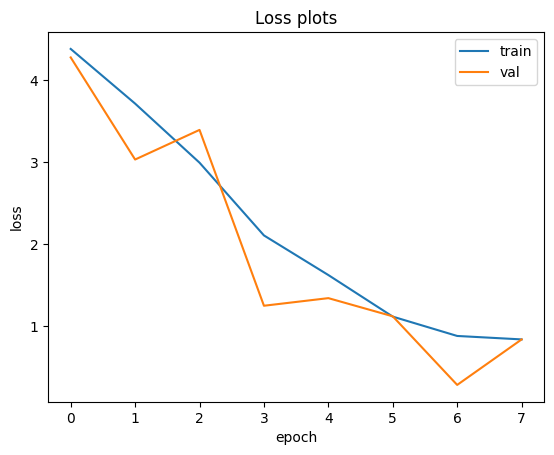

In [17]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Loss plots')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.show()
plt.savefig('loss.jpg')

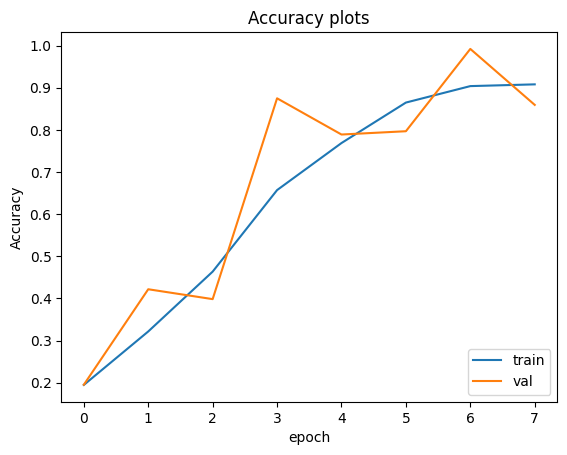

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_accs)
plt.plot(val_accs)
plt.title('Accuracy plots')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
#plt.show()

plt.savefig('accuracy.jpg')

In [ ]:
import matplotlib.pyplot as plt


def get_image_loader():
    'Generates one sample of data'
    jig_size = 4


    data_transform = transforms.Compose([
        # transforms.ColorJitter(brightness=[0.5, 1.5]),
        transforms.ToTensor(),
    ])

    # Select sample
    file_path = "extraimages/extra-image-1.jpg"
    pil_image = Image.open(file_path)

    # Convert image to torch tensor
    pil_image = pil_image.resize((256, 256))
    new_size = 256 - (256 % jig_size) # Ensure that the number of pixels fits the number of jigsaw pieces
    pil_image = crop_from_center(pil_image, new_size, new_size)
    solution_tensor = data_transform(pil_image)

    # Split image into tiles (patches)
    crops = get_several_crops(pil_image, jig_size)

    # Generate a rotation sequence
    rot_config = np.random.randint(4, size=jig_size ** 2)

    # Find a single patch in the image
    rand_pos = np.random.randint(jig_size ** 2)
    rand_rot = np.random.randint(4) # Set to 0 for debugging purposes
    patch_im = crops[rand_pos]
    patch_im = rotate(patch_im, rand_rot * 90)
    patch_tensor = data_transform(patch_im)
    pad_size_right = solution_tensor.shape[2] - patch_tensor.shape[2]
    pad_size_bottom = solution_tensor.shape[1] - patch_tensor.shape[1]
    patch_tensor_extended = torch.nn.functional.pad(patch_tensor, (0, pad_size_right, 0, pad_size_bottom))

    # Concanate selected patch along channel to form a 6 channel image
    original_plus_patch = torch.cat((solution_tensor, patch_tensor_extended), dim=0)

    print(patch_im)


    return original_plus_patch, rand_pos, rand_rot, patch_im, pil_image



model = PretrainedResNet()       # create an *uninitialized* instance
state = torch.load("resnet_jigsaw_solver_e1_js_trained.pt", map_location="cpu")
model.load_state_dict(state)
model.eval()
model.to(device)

sing_im, pos, rot, patch, solution = get_image_loader()
print(f"Solution is {pos} and {rot}")
plt.subplot(1, 2, 1)
# plt.axis((0, 64*4, 0, 64*4))
plt.imshow(solution)
plt.subplot(1, 2, 2)
plt.imshow(patch)
sing_im = sing_im.unsqueeze(0).to(device)
pos_out, rot_out = model(sing_im)
pos_pred = pos_out.argmax(dim=1)
rot_pred = rot_out.argmax(dim=1)
print(pos_pred, rot_pred)
print(pos_out, rot_out)


# Solve entire puzzle

In [ ]:
import itertools
import random
import torch
from torchvision import transforms
from torchvision.transforms.functional import rotate
from PIL import Image
import numpy as np

file_path = "extraimages/extra-image-1.jpg"
pil_image = Image.open(file_path)
jigsaw_puzzle_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




def crop_from_center(pil_image, new_h, new_w):

    width, height = pil_image.size  # Get dimensions

    left = (width - new_w) / 2
    top = (height - new_h) / 2
    right = (width + new_w) / 2
    bottom = (height + new_h) / 2

    # Crop the center of the image
    pil_image = pil_image.crop((left, top, right, bottom))

    return pil_image

def get_several_crops(pil_image, jig_size):
    """
    Get several crops for a square pillow image. That is height and width of the image should be same.
    :param pil_image: pillow image
    :param jig_size: number of rows and columns for jigsaw
    :return: List of pillow images. The nine crops
    """
    w, h = pil_image.size
    diff = int(w/jig_size)

    r_vals = [i * diff for i in range(jig_size)]
    c_vals = [i * diff for i in range(jig_size)]

    list_patches = []

    for r in r_vals:
        for c in c_vals:

            left = c
            top = r
            right = c + diff
            bottom = r + diff

            patch = pil_image.crop((left, top, right, bottom))
            list_patches.append(patch)

    return list_patches

def shuffle_image(file_path):
    jig_size = 4


    data_transform = transforms.Compose([
        # transforms.ColorJitter(brightness=[0.5, 1.5]),
        transforms.ToTensor(),
    ])

    # Select sample
    pil_image = Image.open(file_path)

    # Convert image to torch tensor
    pil_image = pil_image.resize((256, 256))
    new_size = 256 - (256 % jig_size) # Ensure that the number of pixels fits the number of jigsaw pieces
    pil_image = crop_from_center(pil_image, new_size, new_size)
    solution_tensor = data_transform(pil_image)

    # Split image into tiles (patches)
    crops = get_several_crops(pil_image, jig_size)

    # Generate a rotation sequence
    rot_config = np.random.randint(4, size=jig_size ** 2)
    # Generate a position sequence
    # pos_config = np.random.randint(jig_size ** 2, size=jig_size ** 2)
    pos_config = np.arange(jig_size ** 2)
    np.random.shuffle(pos_config)

    # Shuffle the image
    transformed_crops = torch.zeros((jig_size ** 2, 3, crops[0].height, crops[0].width))
    for crop, rot, pos in zip(crops, rot_config, pos_config):
        rotated_crop = rotate(crop, int(rot * 90))
        transformed_crops[pos] = data_transform(rotated_crop)

    # Find a single patch in the image
    rand_pos = np.random.randint(jig_size ** 2)
    rand_rot = np.random.randint(4) # Set to 0 for debugging purposes

    list_original_plus_patch = []
    for tr_cr in transformed_crops:
        # patch_im = crops[rand_pos]
        # patch_im = rotate(patch_im, rand_rot * 90)
        # patch_tensor = data_transform(patch_im)
        pad_size_right = solution_tensor.shape[2] - tr_cr.shape[2]
        pad_size_bottom = solution_tensor.shape[1] - tr_cr.shape[1]
        patch_tensor_extended = torch.nn.functional.pad(tr_cr, (0, pad_size_right, 0, pad_size_bottom))

        # Concanate selected patch along channel to form a 6 channel image
        original_plus_patch = torch.cat((solution_tensor, patch_tensor_extended), dim=0)
        list_original_plus_patch.append(original_plus_patch)


    return list_original_plus_patch, pos_config, rot_config, pil_image

def solve(model, tiles):
    threshold = 0.5
    solution_pos = np.zeros(len(tiles))
    solution_rot = np.zeros(len(tiles))
    taken_pos = []
    taken_rot = []
    i = 0
    itr = 0
    while itr < 1000 and len(taken_pos) < len(tiles):
        t = tiles[i]
        sing_im = t.unsqueeze(0).to(device)
        pos_out_prob, rot_out_prob = model(sing_im)
        pos_out_prob = pos_out_prob.squeeze(0)
        rot_out_prob = rot_out_prob.squeeze(0)
        # print(f"Pos out prob: {pos_out_prob}")
        # print(f"Rot out prob: {rot_out_prob}")
        # print(f"Taken pos: {taken_pos}")

        # # Don't include already taken
        # for i, p, r in zip(range(len(taken_pos)), taken_pos, taken_rot):
        #     pos_out_prob[p] = -10000
        #     rot_out_prob[r] = -10000

        top_pos_prob, pos_idx = torch.topk(pos_out_prob, 2)
        top_rot_prob, rot_idx = torch.topk(rot_out_prob, 2)

        top_pos_prob = top_pos_prob.squeeze(0)
        top_rot_prob = top_rot_prob.squeeze(0)
        pos_idx = pos_idx.squeeze(0)
        rot_idx = rot_idx.squeeze(0)

        # print(top_pos_prob, pos_idx)
        # print(top_rot_prob, rot_idx)
        if top_pos_prob[0] > 3:
            solution_pos[i] = pos_idx[0]
            solution_rot[i] = rot_idx[0]
            taken_pos.append(pos_idx[0])
            taken_rot.append(rot_idx[0])

        pos_pred = pos_out_prob.argmax(dim=0)
        rot_pred = rot_out_prob.argmax(dim=0)
        i += 1
        itr += 1
        i = i % len(tiles)


    return solution_pos, solution_rot




tiles = get_several_crops(pil_image, jigsaw_puzzle_size)
model_ready, solution_pos, solution_rot, pil_image = shuffle_image(file_path)

model = PretrainedResNet()       # create an *uninitialized* instance
state = torch.load("resnet_jigsaw_solver_e1_js_trained.pt", map_location="cpu")
model.load_state_dict(state)
model.eval()
model.to(device)

model_pos, model_rot = solve(model, model_ready)
print(f"Should be {solution_pos } and {solution_rot}")
print(f"Return {model_pos} and {model_rot}")




In [ ]:
import torch
from torchvision import transforms
from PIL import Image

num_outputs = num_permuts_saved
siamese_deg = jigsaw_puzzle_size ** 2

# Use same transforms as training
data_transform = transforms.Compose([
    transforms.RandomCrop((64, 64)),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.ToTensor(),
])

data_loader = GetDataset(["mountain_Solution.jpg"], [None], transform=data_transform)
jig_loader = GetJigsawPuzzleDataset(["mountain_Solution.jpg"], 'selected_permuts.npy', transform=data_transform, jig_size=jigsaw_puzzle_size)


model = resnet18(num_classes=num_outputs, siamese_deg=siamese_deg, jigsaw_size=jigsaw_puzzle_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("resnet_jigsaw_solver_e1_js_trained.pt"))
model.to(device)
model.eval()

X, y = jig_loader[0]
X = X.unsqueeze(0).to(device)

with torch.no_grad():
  output = model(X)

print("Output shape: ", output.shape)
out_im = transforms.functional.to_pil_image(output)

out_im.show()

print(output)

In [ ]:
import argparse
import os

import numpy as np
import pandas as pd

import torch
from PIL import Image
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torch import nn
from torchvision import models
from torch.autograd import Variable


def pil_loader(path):
    pil_img = Image.open(path)
    if pil_img.mode == "L":
        return None
    else:
        return pil_img


if __name__ == '__main__':


    Cmodel_name = 'resnet_trained_ssl_e1_last_b_last_b_ft.pt'
    Ctest_compact_bilinear = True
    Ctest_imagenet_based = False
    Ctest_on = 'test'

    # Set device to use to gpu if available and declare model_file_path
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #par_weights_dir = 'weights/'
    model_file_path = Cmodel_name

    # Data loading and data generators set up
    train_image_ids, test_image_ids, train_file_paths, test_file_paths, train_labels, test_labels = \
        get_train_test_file_paths_n_labels()

    train_image_ids, val_image_ids, train_file_paths, val_file_paths, train_labels, val_labels = \
        split_train_into_train_val(train_image_ids, train_file_paths, train_labels, test_size=0.1)

    if Ctest_imagenet_based:
        model_to_train = models.resnet18(pretrained=True)
        model_to_train.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        model_to_train.fc = nn.Sequential(
            nn.Dropout(),
            nn.Linear(2048, 5),
            nn.LogSoftmax()
        )
    else:
        model_to_train = resnet18(num_classes=5, siamese_deg=None, jigsaw_size=jigsaw_puzzle_size)

    # Check if saved model exists, and load if it does.
    if os.path.exists(model_file_path):
        model_to_train.load_state_dict(torch.load(model_file_path))
    model_to_train.to(device)

    # Setup on which set evaluation is to be carried out
    if Ctest_on == 'train':
        eval_file_paths, eval_labels = train_file_paths, train_labels
    elif Ctest_on == 'val':
        eval_file_paths, eval_labels = val_file_paths, val_labels
    else:
        eval_file_paths, eval_labels = test_file_paths, test_labels

    # Start evaluation
    model_to_train.eval()
    correct = 0
    preds = []
    for f, label in zip(eval_file_paths, eval_labels):
        pil_img = pil_loader(f)
        if pil_img is None:
            preds.append(0)
            continue
        data = def_data_transform(pil_img)
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = Variable(data, volatile=True).to(device)
        output = model_to_train(data)
        pred = output.data.max(1, keepdim=True)[1]

        x = pred.data #prediction
        preds.append(x)

        if x == label:
            correct += 1

    print (correct, len(eval_file_paths), correct * 100 / len(eval_file_paths))
    preds = np.array(preds).astype(np.float64)
    conf_mat = np.array(confusion_matrix(preds, eval_labels))
    conf_df = pd.DataFrame(conf_mat)
    conf_df.columns = np.arange(0,5)
    conf_df.to_csv('confusion_matrix.csv')